In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
import pyro

In [3]:
pr_pos_vamp = 0.95
pr_pos_mortal = 0.01
pr_vamp = 0.001
pr_pos = pr_pos_vamp * pr_vamp + pr_pos_mortal * (1 - pr_vamp)
pr_vamp_pos = pr_pos_vamp * pr_vamp / pr_pos
pr_vamp_pos

0.08683729433272395

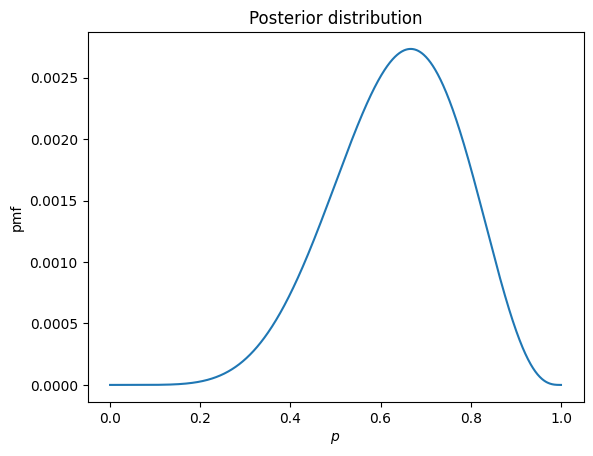

In [4]:
p_grid = np.linspace(0, 1, 1000)
prob_p = np.ones(1000)
prob_data = st.binom(n=9, p=p_grid).pmf(6)
posterior = prob_data * prob_p
posterior /= sum(posterior)
plt.plot(p_grid, posterior)
plt.title("Posterior distribution")
plt.xlabel("$p$")
plt.ylabel("pmf")
plt.show()

In [5]:
samples = np.random.choice(p_grid, p=posterior, size=10000)

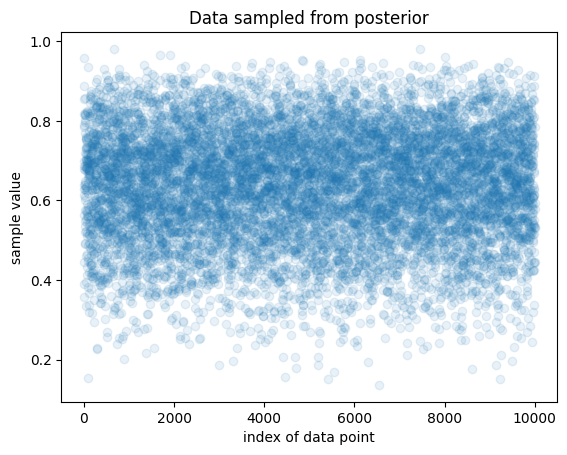

In [6]:
plt.scatter(range(len(samples)), samples, alpha=0.1)
plt.title("Data sampled from posterior")
plt.xlabel("index of data point")
plt.ylabel("sample value")
plt.show()    


/tmp/ipykernel_7017/2070995479.py:2: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  y = st.kde.gaussian_kde(samples, bw_method=0.15).pdf(x)


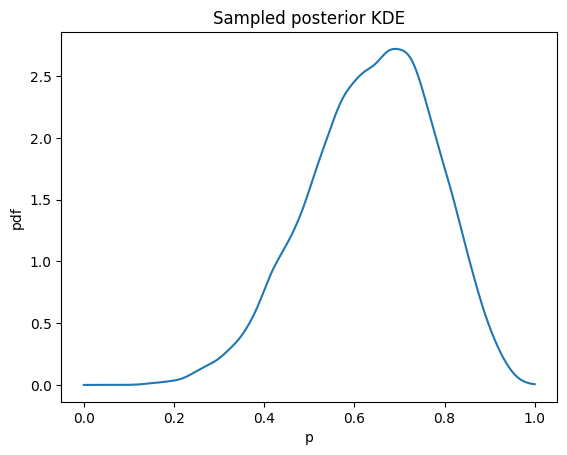

In [7]:
x = np.linspace(0, 1, 1000)
y = st.kde.gaussian_kde(samples, bw_method=0.15).pdf(x)
plt.plot(x, y)
plt.title("Sampled posterior KDE")
plt.xlabel("p")
plt.ylabel("pdf")
plt.show()  

0.1718745890202287


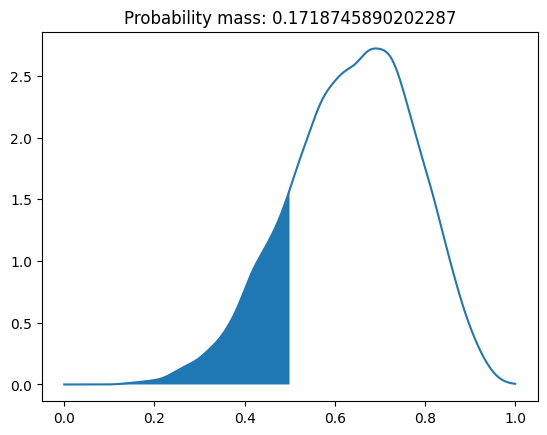

In [8]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = posterior[p_grid<0.5].sum()
print(p)
plt.title(f"Probability mass: {p}")
plt.show()

0.1694


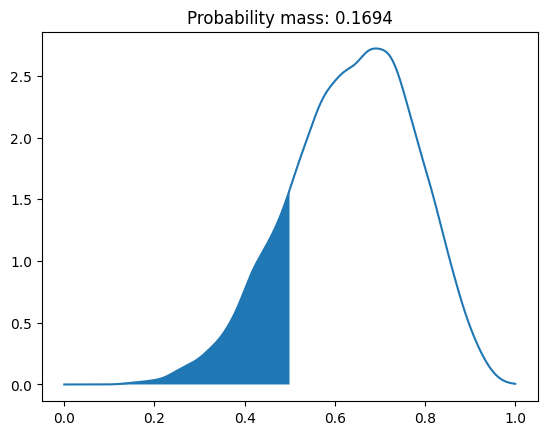

In [9]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = (samples < 0.5).sum()/len(samples)
print(p)
plt.title(f"Probability mass: {p}")
plt.show()

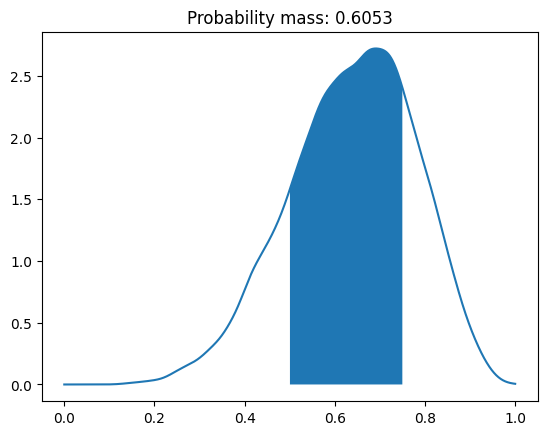

In [10]:
plt.plot(p_grid, y)
mask = (0.5<x) & (x<0.75)
plt.fill_between(x[mask], y[mask], 0)
p = ((0.5 < samples) & (samples < 0.75)).sum()/len(samples)
plt.title(f"Probability mass: {p}")
plt.show()

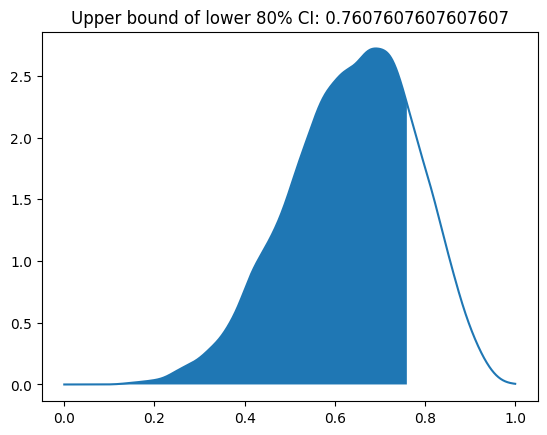

In [11]:
plt.plot(p_grid, y)
q = np.quantile(samples, 0.8)
mask = (x<q)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Upper bound of lower 80% CI: {q}")
plt.show()

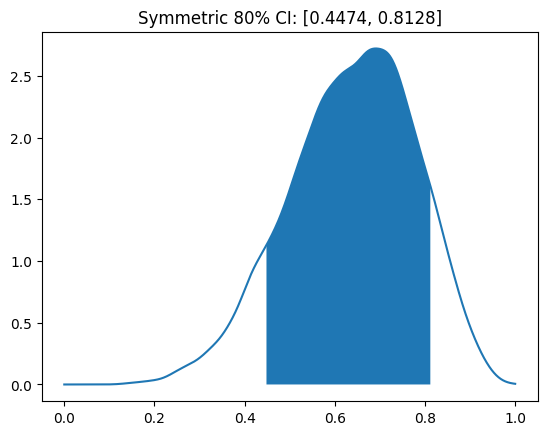

In [12]:
plt.plot(p_grid, y)
q1, q2 = np.quantile(samples, [0.1, 0.9])
mask = (q1<x) & (x<q2)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Symmetric 80% CI: [{q1:.4f}, {q2:.4f}]")
plt.show()

In [13]:
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = st.binom(n=3, p=p_grid).pmf(3)
posterior = likelihood * prior
posterior /= posterior.sum()
# Sample from posterior
samples = np.random.choice(p_grid, size=10000, p=posterior)

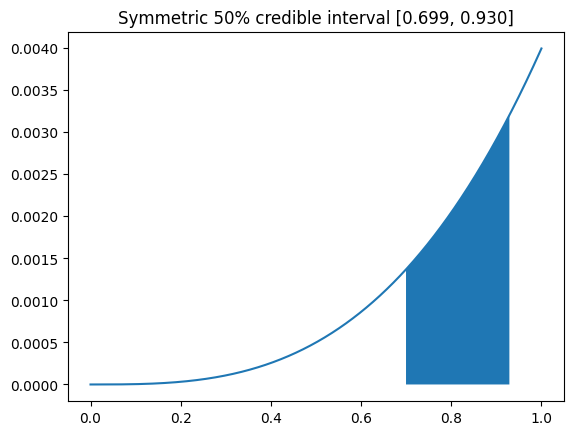

In [14]:
plt.plot(p_grid, posterior)
q1, q2 = np.quantile(samples, [0.25, 0.75])
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"Symmetric 50% credible interval [{q1:.3f}, {q2:.3f}]")
plt.show()

In [15]:
def HPDI(samples, prob):
    samples = sorted(samples)
    N = len(samples)
    W = int(round(N*prob))
    min_interval = float('inf')
    bounds = [0, W]
    for i in range(N-W):
        interval = samples[i+W] - samples[i]
        if interval < min_interval:
            min_interval = interval
            bounds = [i, i+W]
    return samples[bounds[0]], samples[bounds[1]]

In [16]:
HPDI(samples, 0.5)

(np.float64(0.8358358358358359), np.float64(0.998998998998999))

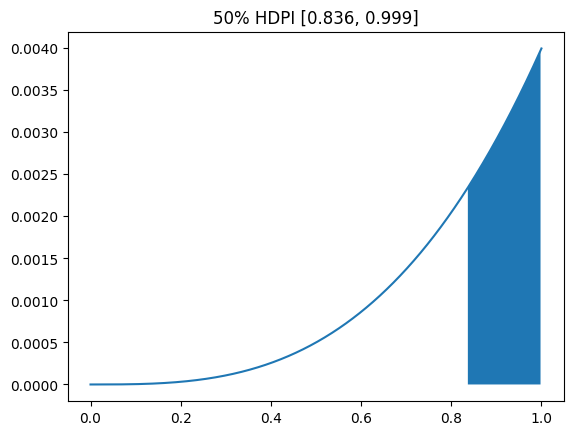

In [17]:
plt.plot(p_grid, posterior)
q1, q2 = HPDI(samples, 0.5)
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"50% HDPI [{q1:.3f}, {q2:.3f}]")
plt.show()

In [18]:
p_grid[np.argmax(posterior)]

np.float64(1.0)

In [19]:
counts, bins = np.histogram(samples, bins=50)
i = np.argmax(counts)
(bins[i] + bins[i+1])/2

np.float64(0.9719819819819819)

In [20]:
print(f"mean: {samples.mean()}")
print(f"median: {np.median(samples)}")

mean: 0.7951804804804805
median: 0.8368368368368369


In [21]:
sum(posterior * abs(0.5 - p_grid))

np.float64(0.3128751874998122)

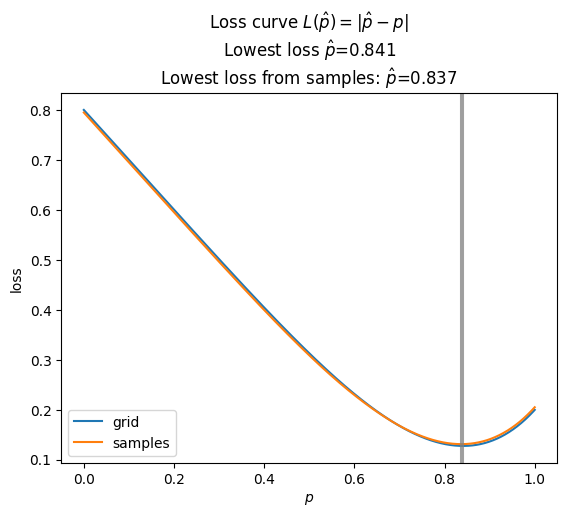

In [22]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid] # Using grid estimate posterior
loss_sampled = [abs(p - samples).mean() for p in p_grid] # Using posterior samples
min_loss = p_grid[np.argmin(loss)]
min_loss_sampled = p_grid[np.argmin(loss_sampled)]
plt.plot(p_grid, loss, label="grid")
plt.plot(p_grid, loss_sampled, label="samples")
plt.axvline(min_loss, color="grey", alpha=0.75)
plt.axvline(min_loss_sampled, color="grey", alpha=0.75)
plt.title(
    "Loss curve $L(\hat{p}) = |\hat{p} - p|$\nLowest loss $\hat{p}$="
    f"{min_loss:.3f}\n""Lowest loss from samples: $\hat{p}$="
    f"{min_loss_sampled:.3f}"
)
plt.xlabel("$p$")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
st.binom(n=2, p=0.7).pmf([0, 1, 2])

array([0.09, 0.42, 0.49])

In [24]:
st.binom(n=2, p=0.7).rvs(10)

array([2, 0, 1, 0, 2, 1, 2, 0, 2, 1])

In [25]:
W=st.binom(n=2, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
W = np.stack([vals, counts/len(W)])
print(W)

[[0.      1.      2.     ]
 [0.09168 0.41923 0.48909]]


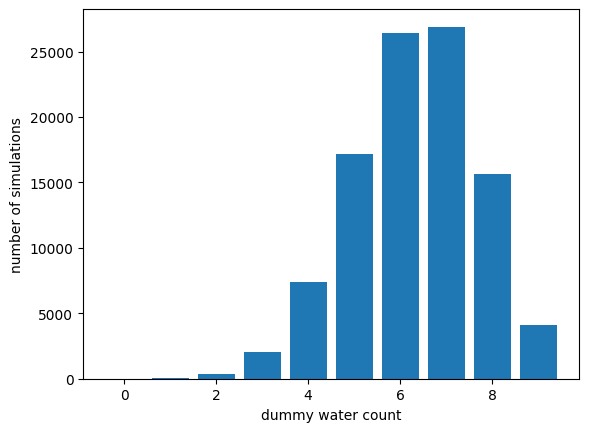

In [26]:
W = st.binom(n=9, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()

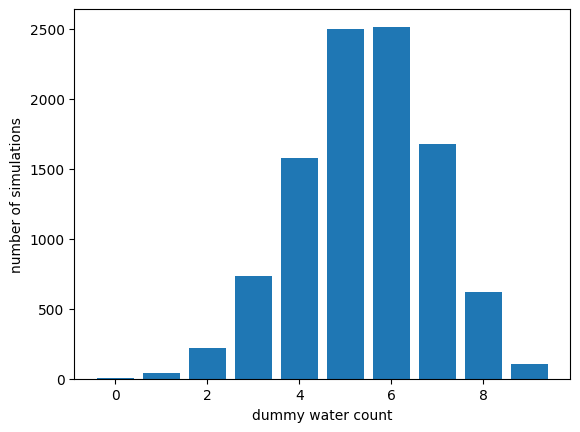

In [27]:
W = st.binom(n=9, p=0.6).rvs(10_000) 
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()

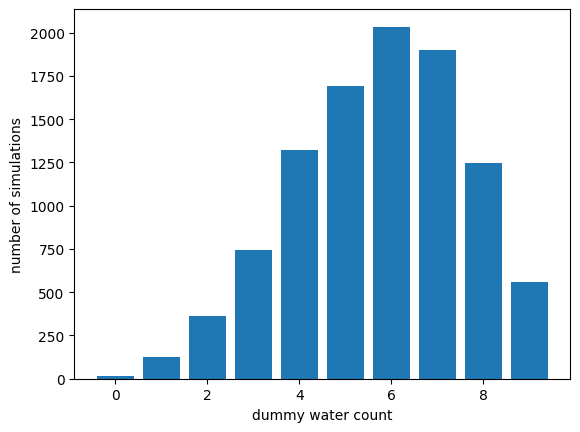

In [28]:
samples = st.beta(6+1, 3+1).rvs(10_000) # sample 10k times from analytic posterior (W=6, L=3)
W = st.binom(n=9, p=samples).rvs() # sample from posterior predictive
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.show()